In [1]:
# See https://github.com/CINPLA/pyopenephys
%load_ext autoreload
%autoreload 2
import pyopenephys
from utils.custom_functions import *
import matplotlib.pylab as plt
import numpy as np
import math
import sys
import os
sys.path.append("../") # go to parent 
from BehaviouralAnalysis.utils.plot_utils import axvlines
import quantities as pq
from scipy.signal import filtfilt
import copy
import matplotlib
%matplotlib inline
import pickle

In [5]:
# 1. read data
GeneralDataDir = '/home/hernandom/data/Ephys_data/invitro/OEdata/'
Experiment = 'test_2020-02-13_17-02-14'
file = pyopenephys.File(GeneralDataDir + Experiment)
experiments = file.experiments
experiment1 = experiments[1]
recordings = experiment1.recordings
recording = recordings[0]
analog_signals = recording.analog_signals
signals = analog_signals[0]
events_data = recording.events
events = events_data[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format
.dat:  continuous.dat
Estimated samples:  5746176  Numchan:  72
Duration:  191.53916666666666 1/Hz
Sampling Rate:  30000.0 Hz


In [14]:
# get TTLs
rawTTLs = getTTLs(recording.events[0])[0]
# classify the pulses and save them into a diccionary
soundPresentationTimes = getFirstPulses(rawTTLs, 4) #Detect first events (separated by at least 4 seconds)
TTLs = {
        'soundPresentationTimes': soundPresentationTimes,
        'soundOffsetTimes': np.setdiff1d(rawTTLs, soundPresentationTimes), #get sound offset
}
# get the difference (THIS ASSUMES IS ALWAYS THE SAME) For plotting purposes so far
offset_delay = np.median(TTLs['soundOffsetTimes'] - TTLs['soundPresentationTimes']).item()

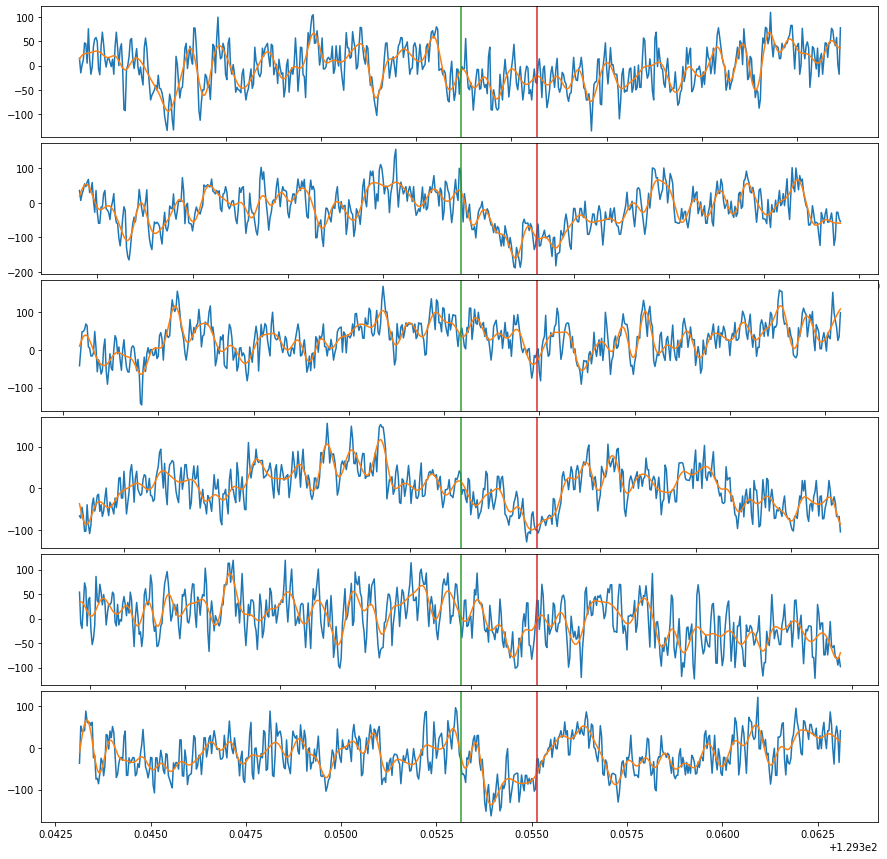

In [18]:
# FILTER TEST
ChID = 29
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 2000
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_lowpass(Filter_High_Value, recording.sample_rate)
fd = filtfilt(b, a, signals.signal[ChID])

# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(6, 1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()

for i in range(6):
    pulseTime = TTLs['soundPresentationTimes'][i*5].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.01 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.01 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChID][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],fd[pFS:pFF])
    axvlines(pulseTime, ax=axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*5].item(), ax=axs[i])

plt.show()


In [19]:
# 2. filter the data
Filter_Low_Value = 100
Filter_High_Value = 1000
filteredData = copy.deepcopy(signals.signal)
#b,a = butter_lowpass(600, recording.sample_rate)
b,a = butter_bandpass(Filter_Low_Value, Filter_High_Value, recording.sample_rate)
for electrodeID in range(64):
    filteredData[electrodeID] = filtfilt(b, a, signals.signal[electrodeID])
    update_progress(electrodeID / 64)
update_progress(1)

Progress: [####################] 100.0%


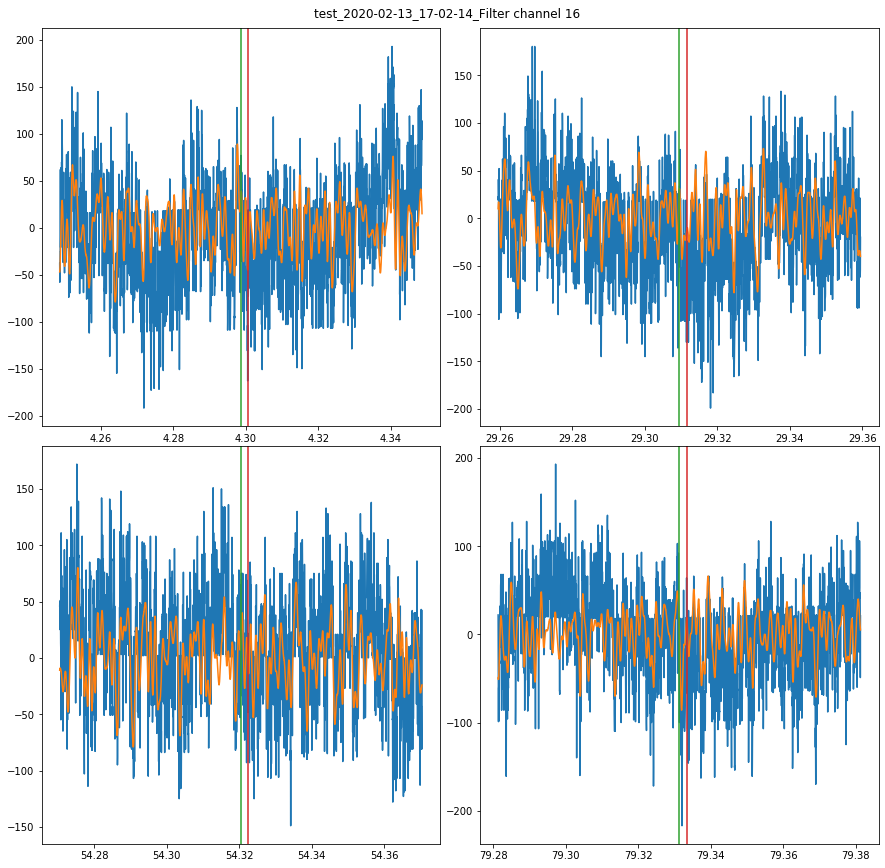

In [20]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 16
# Plot some examples (first, 5th, 10th and 15th pulse)
fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.1)
axs = axs.ravel()
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)

for i in range(4):
    pulseTime = TTLs['soundPresentationTimes'][i*5].item()
    pulseFrame = int(pulseTime * recording.sample_rate.item())
    pFS = int(pulseFrame - 0.05 * recording.sample_rate.item())
    pFF = int(pulseFrame + 0.05 * recording.sample_rate.item())
    #extract frames around the pulse
    axs[i].plot(signals.times[pFS:pFF],signals.signal[ChId][pFS:pFF])
    axs[i].plot(signals.times[pFS:pFF],filteredData[ChId][pFS:pFF])
    axvlines(pulseTime, ax = axs[i])
    axvlines(TTLs['soundOffsetTimes'][i*5].item(), ax=axs[i])
#plt.savefig(OutPutDir + Experiment + '_FilteredSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

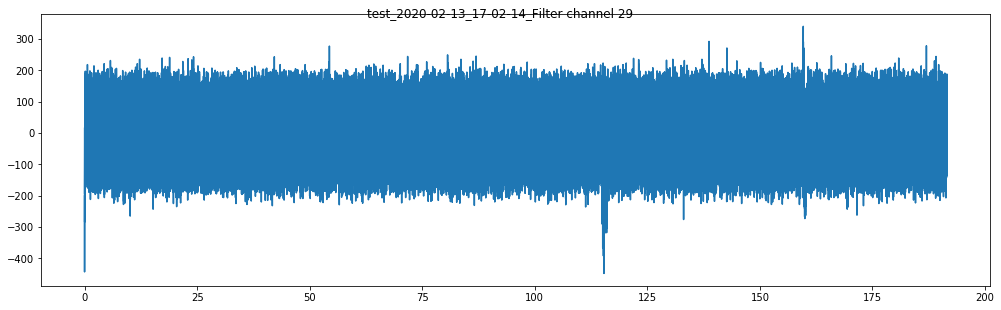

In [21]:
# Check point
# Check how the filtered data looks like
# Select a channel
ChId = 29
# Plot some examples (first, 10th, 20th and 30th pulse)
fig, axs = plt.subplots(1, 1, figsize=(17, 5), facecolor='w', edgecolor='k')
plt.suptitle(Experiment + '_Filter channel ' + str(ChId), y=0.9)
axs.plot(signals.times,signals.signal[ChId])
plt.show()

In [22]:
# 3. align data
# interval for traces alignment. In seconds. Range of alignment
intervalWindow = [-0.02,0.04]
#firstpulses  = getFirstPulses(events.times, .5)
traces_aligned = alignTrace(filteredData, signals.times, TTLs['soundPresentationTimes'], intervalWindow, recording.sample_rate)
intervalTimes = np.arange(intervalWindow[0], intervalWindow[1], 1/recording.sample_rate.base)
print(Experiment + ' analyzed...')

test_2020-02-13_17-02-14 analyzed...


In [23]:
# 4. translate data
# seconds to calculate the mean before 0 and translate each trace
sToSubstract = 0.005
traces_translated = copy.deepcopy(traces_aligned)
for electrodeID in range(len(traces_translated)):
    for traceID in range(len(traces_translated[electrodeID])):        
        traces_translated[electrodeID][traceID] = translateTrace(traces_aligned[electrodeID][traceID], intervalTimes, recording.sample_rate, sToSubstract)   
    update_progress(electrodeID / len(traces_translated))
update_progress(1)

Progress: [####################] 100.0%


Progress: [####################] 98.6%


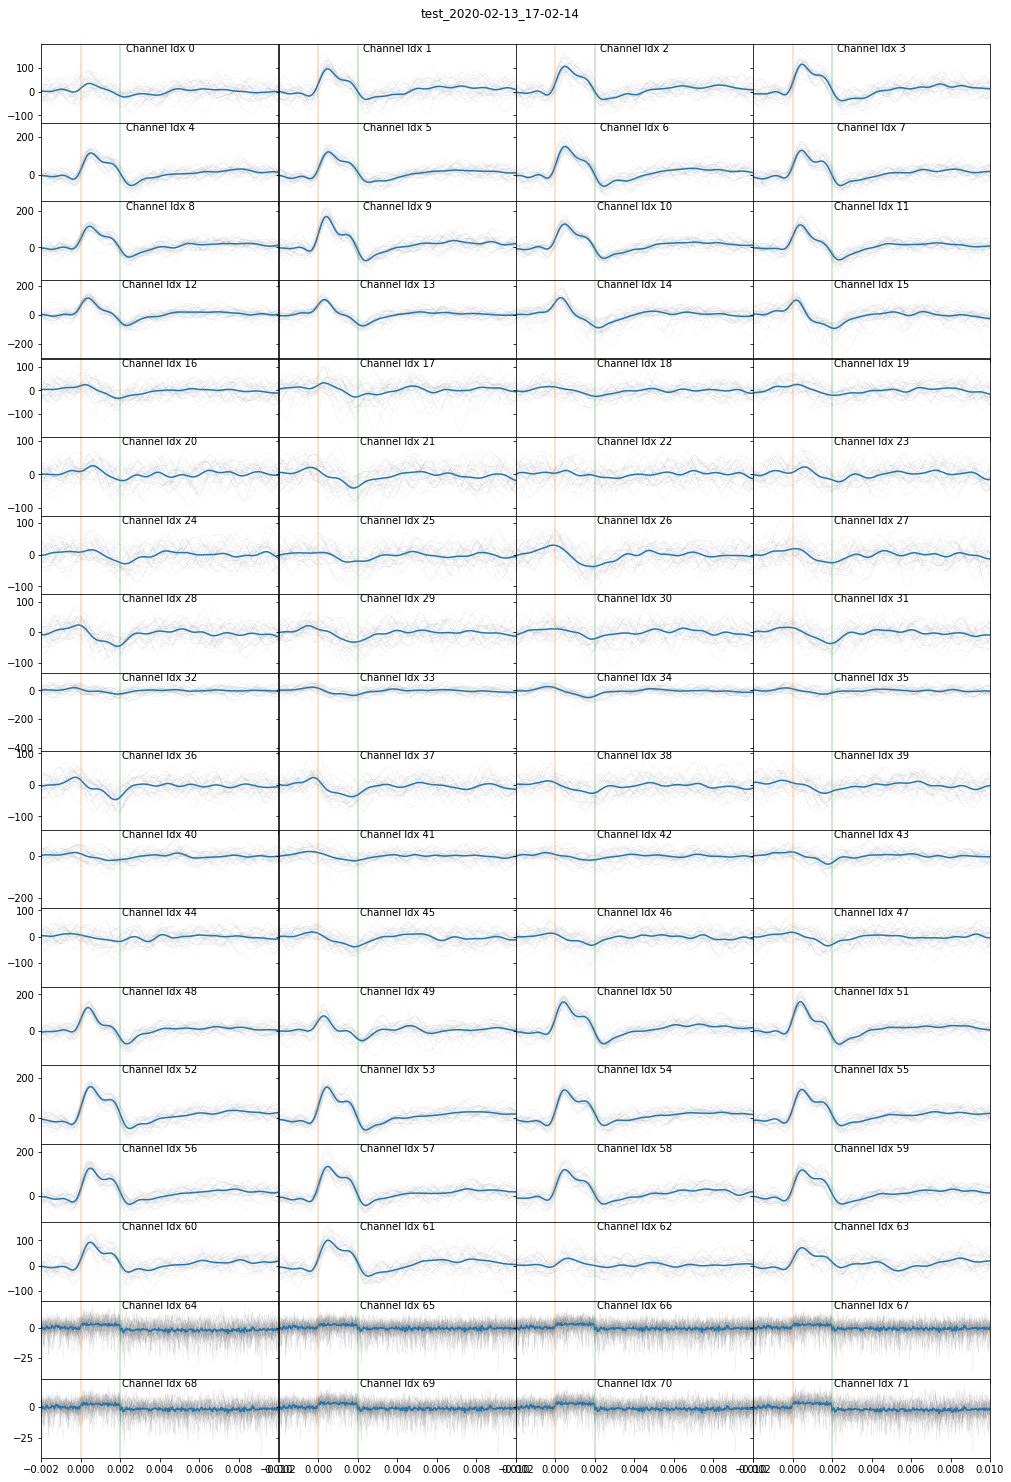

In [24]:
# Check-point. Plot the signal of each channel
fig, axs = plt.subplots(math.ceil(len(traces_translated)/4), 4, figsize=(17, 26), facecolor='w', edgecolor='k', sharex=True, sharey='row')
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
plt.suptitle(Experiment, y=0.9)

# Save the averages
Average_traces = [None] * len(traces_translated)

for j in range(len(traces_translated)):
    for i in range(traces_translated[j].shape[0]):
        axs[j].plot(intervalTimes, traces_translated[j][i,], color = 'grey', linewidth = 0.1, alpha = 0.6)
    avg = np.mean(traces_translated[j], axis = 0)
    Average_traces[j] = avg
    axs[j].plot(intervalTimes, avg)
    # zoom in the curve
    axs[j].set_xlim(-0.002, 0.01)
    axs[j].text(.5,.9,"Channel Idx "+str(signals.channel_id[j]), horizontalalignment='center', transform=axs[j].transAxes)
    update_progress(j / len(traces_translated))
    
for j in range(len(traces_translated)):    
    axvlines(0, alpha = 0.3, ax = axs[j])
    axvlines(offset_delay, alpha = 0.3, ax = axs[j])
#plt.savefig(OutPutDir + Experiment + '_AlignedSignal.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# check how they map to the electrodes in the probe